## ex6 Support vector machines with linear and Gaussian kernel

In this exercise, we use support vector machine to build a spam classifier. 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
from scipy.optimize import minimize
from scipy.io import loadmat

###  Part 1: Loading and Visualizing Data 
We start the exercise by first loading and visualizing the dataset.  The following code will load the dataset into your environment and plot the data. The below data can be separated by a linear boundary. The position of the positive examples and negative examples suggests a natural spearation. However there is an outlier of positive example + on the far left about (0.1, 4.1)

In [6]:
# Load from ex6data1: 
# You will have X, y in your environment
data1=loadmat('ex6data1.mat'); # data1 is readin as a dictionary
X=data1['X']
print(X.shape)
y=data1['y']
print(y.shape)

(51, 2)
(51, 1)


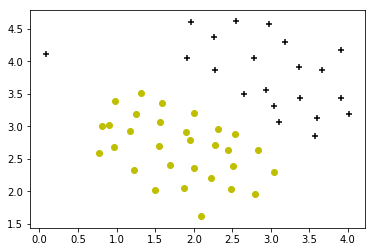

In [7]:
# Plot training data
def plotData(X, y):
# index for y=1
    pos=(y==1)
    neg=(y==0)
    plt.scatter(X[:,0].reshape(-1,1)[pos], X[:,1].reshape(-1,1)[pos], color='k', marker='+')
    plt.scatter(X[:,0].reshape(-1,1)[neg], X[:,1].reshape(-1,1)[neg], color='y', marker='o')
plotData(X, y)

In [33]:
# Create a pandas DataFrame using X,y for future use
df=pd.DataFrame(np.concatenate((X,y), axis=1), columns=['X1','X2','y'] )
print(df.head(2))
print(df.tail(2))
print(df.shape)
print(df.info())


       X1      X2    y
0  1.9643  4.5957  1.0
1  2.2753  3.8589  1.0
          X1      X2    y
49  0.766150  2.5899  0.0
50  0.086405  4.1045  1.0
(51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
X1    51 non-null float64
X2    51 non-null float64
y     51 non-null float64
dtypes: float64(3)
memory usage: 1.3 KB
None


In [34]:
df.describe()

,X1,X2,y
count,51.000000,51.000000,51.000000
mean,2.268780,3.132512,0.411765
std,0.928531,0.753256,0.497050
min,0.086405,1.617700,0.000000
25%,1.572550,2.636000,0.000000
50%,2.275300,3.070900,0.000000
75%,2.955050,3.531400,1.000000
max,4.015000,4.616200,1.000000


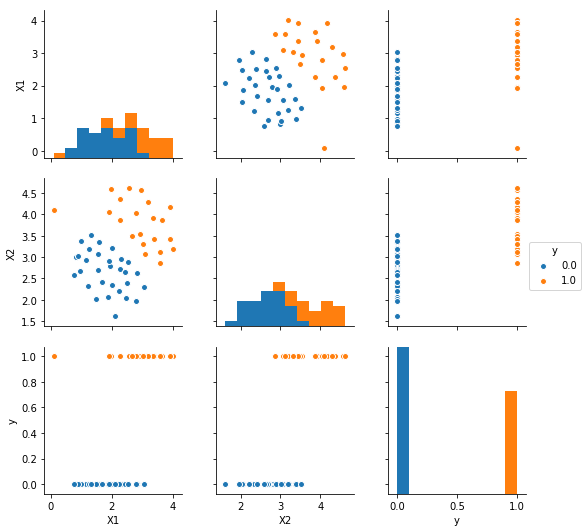

In [44]:
sns.pairplot(df, hue='y')

###  Part 2: Training Linear SVM 

The following code will train a linear SVM on the dataset and plot the decision boundary learned. We will use different C parameter with SVM. The C parameter is a positive value that controls the penalty for misclassified training examples. 
1. C has the same role as 1/lambda for the logistic regression. 
2. A large C parameter tells SVM to classify all the examples correctly. 

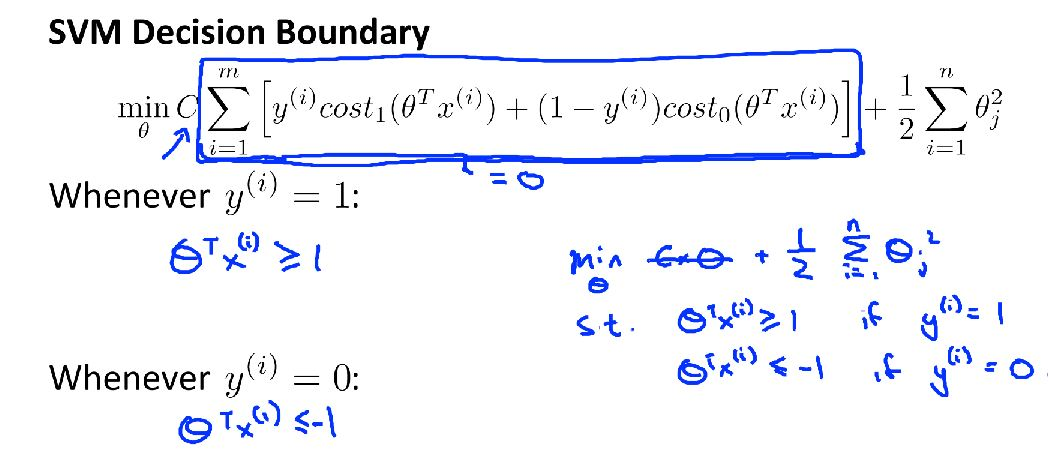

In [48]:
from IPython.display import Image
Image(filename="../pic/SVM decision boundary.jpg", width=500, height=400)

#### 2.1 SVM with linear kernels

In [4]:
# sim = linearKernel(x1, x2) returns a linear kernel between x1 and x2 and returns the value in sim
def linearKernel(x1, x2):
    sim = np.dot(x1.T, x2)  # matrix product
    return sim

In [58]:
from sklearn import svm

def svmTrain(X, y, C, kernelFunction, tol=1e-3, max_passes=-1, sigma=0.1):
    """Trains an SVM classifier"""

    y = y.flatten() # Return a copy of the array collapsed into one dimension.

    if kernelFunction == "gaussian":
        clf = svm.SVC(C = C, kernel="precomputed", tol=tol, max_iter=max_passes, verbose=2)
        return clf.fit(gaussianKernelGramMatrix(X,X, sigma=sigma), y)

    else: 
        clf = svm.SVC(C = C, kernel=kernelFunction, tol=tol, max_iter=max_passes, verbose=2)
        return clf.fit(X, y)

VISUALIZEBOUNDARYLINEAR(X, y, model) plots a linear decision boundary learned by the SVM and overlays the data on it

In [59]:
def visualizeBoundaryLinear(X, y, model):
    intp = model.intercept_
    coef = model.coef_
    # a+b1*x1+b2*x2=0, so x2=-(a+b1*x1)/b2

    xp = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
    yp = - (coef[0,0]*xp + intp)/coef[0,1];
    plotData(X, y);
    plt.plot(xp, yp, color='b'); 

1. try to change the C value below and see how the decision boundary varies (e.g., try C = 1000)
2. C is a positive value that controls the penality of the misclassified training example. 
3. A large C value tells SVM to try to classify all the examples correctly

[LibSVM]

C:\Users\zhang\Anaconda3 new\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Text(0.5,1,'SVM Decision Boundary with C = 1 (Example Dataset 1)')

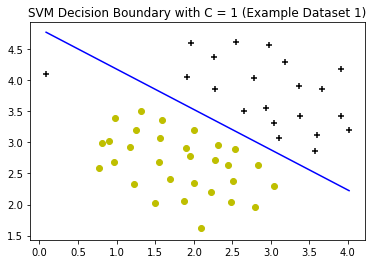

In [60]:
C = 1; 
model = svmTrain(X, y, C, 'linear', 1e-3, 20);
visualizeBoundaryLinear(X, y, model);
plt.title('SVM Decision Boundary with C = 1 (Example Dataset 1)')

[LibSVM]

C:\Users\zhang\Anaconda3 new\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Text(0.5,1,'SVM Decision Boundary with C = 100 (Example Dataset 1)')

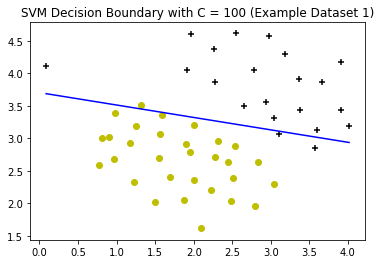

In [62]:
C = 100; 
model = svmTrain(X, y, C, 'linear', 1e-3, 20);
visualizeBoundaryLinear(X, y, model);
plt.title('SVM Decision Boundary with C = 100 (Example Dataset 1)')
# C=100 tries to classify the outlier correct but overfitting

### Part 3 SVM with Gaussian Kernels

1.  with Gaussian Kernel to do non-linear classifier. The Gaussian kernel measures the distance between a pair of examples (xi,xj)
2. It is also parameterized by a bandwidth parameter sigma which determines how fast the similarity metrics decreases to zero. 

<img src="../pic/Gaussian_kernel.jpg">

In [65]:
# sim = gaussianKernel(x1, x2) returns a gaussian kernel between x1 and x2 and returns the value in sim
def gaussianKernel(x1, x2, sigma):
    sim = 0;
    sim=np.exp(-np.dot((x1-x2).T, (x1-x2))/(2*sigma**2))
    return sim
# Test the value of Gaussian kernel
x1 = np.array([1, 2, 1]);
x2 = np.array([0, 4, -1]); 
sigma = 2;
sim = gaussianKernel(x1, x2, sigma);
print('The calculated Gaussian kernel is: ', np.round(sim,6))
print('The true Gaussian kernel is 0.324652')


The calculated Gaussian kernel is:  0.324652
The true Gaussian kernel is 0.324652


In [77]:
def gaussianKernelGramMatrix(x1, x2, sigma):
    sim=np.zeros((x1.shape[0], x2.shape[0]))
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            sim[i,j]=np.exp(-np.dot((x1[i,:]-x2[j,:]).T, (x1[i,:]-x2[j,:]))/(2*sigma**2))
    return sim

#### 3.1 Visualize dataset 2

The following code will load the ex6data2.mat into the environment and plot the data. ex6data2 has a non-linear separation which is suitable for SVM with Gaussian kernel.

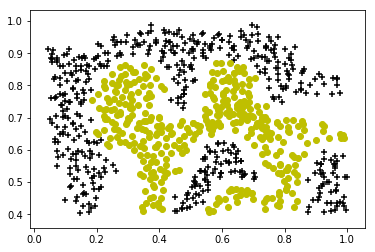

In [75]:
data2=loadmat('ex6data2.mat')
X=data2['X']
y=data2['y']
plotData(X,y)

#### 3.2 Training SVM with Gaussian kernel (dataset 2)

After you have implemented the kernel, we can now use it to train the SVM classifier.

In [78]:
C = 1; 
sigma = 0.1;
model= svmTrain(X, y, C, 'gaussian', tol=1e-3, max_passes=-1, sigma=0.1); 

[LibSVM]

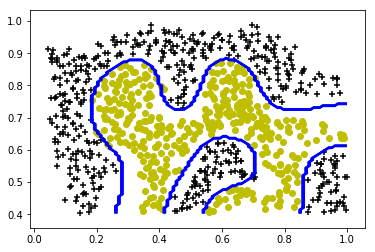

In [85]:
# VISUALIZEBOUNDARY plots a non-linear decision boundary learned by the SVM
def visualizeBoundary(X, y, model, varargin=0):
    plotData(X, y)
    # Make classification predictions over a grid of values
    x1plot = np.linspace(X[:,0].min(), X[:,0].max(), 100).T
    x2plot = np.linspace(X[:,1].min(), X[:,1].max(), 100).T
    X1, X2 = np.meshgrid(x1plot, x2plot)
    vals = np.zeros(X1.shape) #100X100
    for i in range(X1.shape[1]):
       this_X = np.column_stack((X1[:, i], X2[:, i]))  #predict this new observation
       vals[:, i] = model.predict(gaussianKernelGramMatrix(this_X, X, sigma))

    # Plot the SVM boundary
    plt.contour(X1, X2, vals, colors=['b'])
    #plt.show(block=False)
    
visualizeBoundary(X, y, model)

#### 3.3 Visualizing Dataset 3 ex6data3.mat

The following code will load the next dataset into your environment and plot the data. We trains an SVM classifier using the training set (X,y). And we use cross validation set Xval, yval to determine the best C and sigma parameter. 

In [86]:
data3=loadmat('ex6data3.mat')
X=data3['X']
y=data3['y']
Xval=data3['Xval']
yval=data3['yval']
print(X.shape)
print(y.shape)
print(Xval.shape)
print(yval.shape)

(211, 2)
(211, 1)
(200, 2)
(200, 1)


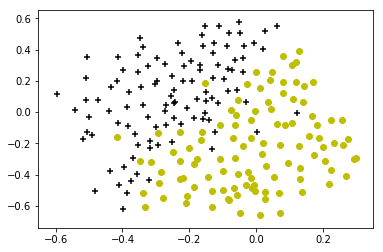

In [87]:
# plotting the training data
plotData(X,y)

#### 3.4 Training SVM with Gaussian Kernel (Dataset 3)

This is a different dataset that you can use to experiment with. Try different values of C and sigma here. When implements the cross validation to select the best C and sigma parameter, we need to evaluate the error on the cross-validation set. For classification, the error is defined as the fraction of cross-validation examples that were classified incorrectly. 

In [107]:
def dataset3Params(X, y, Xval, yval):
    lprecision=list()
    lsigma=list()
    lC=list()
    
    for sigma in [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]:
        for C in [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]:
            model= svmTrain(X, y, C, 'gaussian', tol=1e-3, max_passes=-1, sigma=sigma);  
            predict = model.predict(gaussianKernelGramMatrix(Xval, X, sigma))
            precision=np.mean(yval.flatten()==predict.flatten())*100
            lprecision.append(precision)
            lsigma.append(sigma)
            lC.append(C)

    return lprecision, lsigma, lC


In [108]:
lprecision, lsigma, lC=dataset3Params(X, y, Xval, yval)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [109]:
finaldict={'Precision':lprecision, 'sigma':lsigma, 'C':lC}
precision=pd.DataFrame(finaldict)

In [124]:
print('The best accuracy score is: ', precision['Precision'].max())
print(precision.iloc[precision['Precision'].argmax()])
C=precision.iloc[precision['Precision'].argmax()].loc['C']
sigma=precision.iloc[precision['Precision'].argmax()].loc['sigma']

The best accuracy score is:  96.5
Precision    96.5
sigma         0.1
C             1.0
Name: 20, dtype: float64


C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  
C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


[LibSVM]

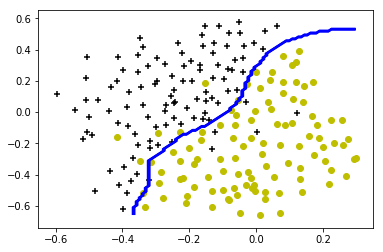

In [127]:
# For the best parameter sigma=0.1, and C=1, SVM returns a decision boundary below.
model = svmTrain(X, y, C, "gaussian", sigma=sigma)
visualizeBoundary(X, y, model)